## Tutorials

In this tutorial, we'll review how to use ``knockpy`` to apply the knockoff framework for variable selection.

### A quick review of knockoffs

In this section, we briefly review the knockoff framework. Users already familiar with knockoffs may want to scroll past this section.

Given a set of $p$ features $X = (X_1, \dots, X_p)$ and an outcome of interest $y$, knockoffs aim to select the small fraction of features on which $y$ actually depends while controlling the false discovery rate. For example, if $y \mid X \sim \mathcal{N}(X \beta, \sigma^2)$ and $\beta$ is sparse, knockoffs aim to identify the set $\{j : \beta_j \ne 0\}$.


Applying the knockoffs framework involves executing three steps.

1. First, we construct synthetic variables $\tilde{X} = (\tilde{X}_1, \dots, \tilde{X}_p)$ called knockoffs. Intuitively, the $j$th knockoff $\tilde{X}_j$ acts as a "negative control" on the $j$th feature $X_j$ during variable selection. In ``knockpy``, knockoffs are denoted as the numpy array ``Xk``. 

2. Second, we use an arbitrary machine learning algorithm -- usually called a *feature statistic* -- to assign variable importances to each of the $p$ features and each of the $p$ knockoffs. For example, we might train a cross-validated Lasso on $[X, \tilde{X}]$ and $y$ and use the lasso coefficient sizes as a measure of variable importance.

3. Intuitively, a non-null feature should be assigned a higher variable importance than its (synthetic) knockoff, whereas knockoffs are constructed such that null features are indistinguishable from their knockoff. The *data-dependent-threshhold* introduced in [Barber and Candes 2015](https://arxiv.org/abs/1404.5609) formalizes this intuition and uses the feature statistics to reject a set of variables such that the expected fraction of false positives is below a prespecified proportion $q$.

There are two main types of knockoffs:

1. **Fixed-X** knockoffs treat the design matrix $X$ as fixed and control the false discovery rate assuming $y \mid X$ follows a homoskedastic gaussian linear response. In this case, it is possible to construct valid knockoffs $\tilde{X}$ with no assumptions on $X$. Note also that when using fixed-X knockoffs, the feature statistic must satisfy a slightly more restrictive *sufficiency* condition (see [Barber and Candes 2015](https://arxiv.org/abs/1404.5609)).

2. **Model-X** knockoffs treat the design matrix $X$ as random. Model-X knockoffs control the false discovery rate for any conditional distribution $y \mid X$, but they assume that the distribution of $X$ is known. Thus, to construct model-X knockoffs, one must know (or estimate) the distribution of $X$. See [Candes et al. (2018)](https://arxiv.org/abs/1610.02351) for details. 

### The ``KnockoffFilter`` class

The ``knockpy.KnockoffFilter`` is the most important class in ``knockpy``: it generates knockoffs, fits the feature statistics, and applies the data-dependent threshhold all at once. This is demonstrated below.

First we create a synthetic dataset where $X \sim \mathcal{N}(0, \Sigma)$ for some $\Sigma$ and $y \mid X$ Gaussian with homoskedastic errors. The details of this dataset are commented below, but they aren't too important.

In [1]:
# Create a random covariance matrix for X
import numpy as np
import knockpy
import warnings

np.random.seed(123)
n = 300  # number of data points
p = 500  # number of features
Sigma = knockpy.dgp.AR1(p=p, rho=0.5)  # Stationary AR1 process with correlation 0.5

# Sample X
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=(n,))

# Create random sparse coefficients
beta = knockpy.dgp.create_sparse_coefficients(p=p, sparsity=0.1)
y = np.dot(X, beta) + np.random.randn(n)

Next, we instantiate the ``KnockoffFilter`` class. To do this, we need to specify (i) what type of knockoff sampler we will use and (ii) what feature statistic we are using. Since $X \sim \mathcal{N}(0, \Sigma)$, we will use Gaussian knockoffs, and we'll use the Lasso as our feature statistic, since it's a good all-around choice. We'll explore more options for these arguments later.

In [2]:
from knockpy import KnockoffFilter

kfilter = KnockoffFilter(
    ksampler="gaussian",
    fstat="lasso",
)

Next, we run the knockoff filter on our data using the ``forward`` method. Since we are using a model-X approach, we initially pass $\Sigma$ as an input to the knockoff filter.

In [3]:
# Flags of whether each feature was rejected
rejections = kfilter.forward(
    X=X,
    y=y,
    Sigma=Sigma,
    fdr=0.1,  # desired level of false discovery rate control
)
# Check the number of discoveries we made
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.around(100 * np.dot(rejections, beta == 0) / rejections.sum())
print(
    f"The knockoff filter has discovered {100 * power}% of the non-nulls with a FDP of {fdp}%"
)

The knockoff filter has discovered 100.0% of the non-nulls with a FDP of 4.0%


Of course, in most real applications, we do not know $\Sigma$. In these cases, the knockoff filter will automatically infer $\Sigma$ using LedoitWolf or GraphicalLasso covariance estimation. Although this invalidates the exact validty of model-X knockoffs, knockoffs have been shown to be fairly robust in this setting.

In [5]:
# Try again with estimated cov matrix
kfilter2 = KnockoffFilter(ksampler="gaussian", fstat="lasso")
rejections = kfilter.forward(X=X, y=y, fdr=0.1, shrinkage="ledoitwolf")
# Check the number of discoveries we made
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.around(100 * np.dot(rejections, beta == 0) / rejections.sum(), 2)
print(
    f"The knockoff filter has discovered {100 * power}% of the non-nulls with a FDP of {fdp}%"
)

The knockoff filter has discovered 100.0% of the non-nulls with a FDP of 9.09%


### Constructing knockoffs

#### Gaussian knockoffs galore

There are many ways to generate Gaussian knockoffs. The default option is to generate MVR knockoffs, which (informally) maximize $\text{Var}(X_j \mid X_{-j}, \tilde{X})$ for each feature $X_j$, where $X_{-j}$ denotes all of the features except the $j$th feature. Intuitively, this  *minimizes the varianced-based reconstructability (MVR)* between the features and their knockoffs, preventing a feature statistic like a lasso or a randomforest from using the other features and knockoffs to *reconstruct* non-null features. See [Spector and Janson (2020)](https://arxiv.org/abs/2011.14625) for more details. 

There are a variety of other options to choose from, including:

- MAXENT knockoffs maximize the entropy of $[X, \tilde{X}]$, which is equivalent to minimizing the mutual information between $X$ and $\tilde{X}$. See [Gimenez and Zou (2019)](https://arxiv.org/abs/1810.11378) or [Spector and Janson (2020)](https://arxiv.org/abs/2011.14625) for more details.
- SDP knockoffs minimize the mean absolute covariance (MAC) between features and their knockoffs.
- Equicorrelated knockoffs also minimize the MAC, but with a constraint that increases computational efficiency and (usually) reduces statistical power. See [Barber and Candes 2015](https://arxiv.org/abs/1404.5609) for a discussion.
- Conditional Independence (CI) knockoffs guarantee that each feature $X_j$ and its knockoff $\tilde{X}_j$ are conditionally independent given all of the other features $X_{-j}$; however, CI knockoffs do not always exist, so we use a heuristic defined in [Ke et al. (2020)](https://arxiv.org/abs/2010.08132) in general.

``knockpy`` supports all of these knockoff generation methods for "gaussian" and "fx" knockoff types. Naturally, it is also possible to use any of these types of knockoffs as proposals for the Metropolized knockoff sampler.

In [5]:
# This uses gaussian maxent knockoffs
kfilter1 = KnockoffFilter(ksampler="gaussian", knockoff_kwargs={"method": "maxent"})

# This uses fixed-X SDP knockoffs
kfilter2 = KnockoffFilter(ksampler="fx", knockoff_kwargs={"method": "sdp"})

# Metropolized sampler for heavy-tailed t markov chain using MVR-guided proposals
kfilter3 = KnockoffFilter(ksampler="artk", knockoff_kwargs={"method": "mvr"})

# The 'method' options include: equicorrelated, sdp, mvr, maxent, and ci.

Knockpy provides this functionality by offering very fast solvers for generating the knockoff $S$-matrix, as detailed below:

In [6]:
import time

# Solve MVR, maxent, and SDP optimization problems for p = 500
time0 = time.time()
S_MVR = knockpy.smatrix.compute_smatrix(Sigma, method="mvr")
time1 = time.time()
mvr_time = np.around(time1 - time0, 1)
S_MAXENT = knockpy.smatrix.compute_smatrix(Sigma, method="maxent")
time2 = time.time()
maxent_time = np.around(time2 - time1, 1)
S_SDP = knockpy.smatrix.compute_smatrix(Sigma, method="sdp")
time3 = time.time()
sdp_time = np.around(time3 - time2, 1)
print(
    f"For p={Sigma.shape[0]}, MVR took {mvr_time} sec, Maxent took {maxent_time} sec, SDP took {sdp_time} sec"
)

For p=500, MVR took 2.6 sec, Maxent took 6.0 sec, SDP took 7.8 sec


#### Metropolized knockoff sampling

``knockpy`` implements a fully general covariance-guided Metropolized knockoff sampler, which is capable of sampling model-X knockoffs for any $X$ distribution given an (unnormalized) density function of $X$. This Metropolized knockoff sampler uses a variety of computational tricks to make it orders of magnitude faster than a naive implementation, although these tricks only work when the distribution of $X$ has conditional independence properties, as specified by an undirected graphical model. See [Bates et al. (2020)](https://arxiv.org/abs/1903.00434) for more details.

The API reference as well as the source for the metro module details more advanced usage of metro; however, for now, we simply demonstrate how to pass in an arbitrary log-likelihood function to the ``MetropolizedKnockoffSampler`` class and use it to sample knockoffs.

In [6]:
import knockpy.metro

# Fake variables for simplicity.
p = 30
n = 300
X_metro = np.random.randn(n, p)
beta = knockpy.dgp.create_sparse_coefficients(p)
y_metro = np.dot(X_metro, beta) + np.random.randn(n)

# An arbitrary (unnormalized) log-likelihood function
rhos = np.random.randn(p)


def log_likelihood(X):
    return np.sum(X[:, 0:-1] * rhos[0:-1] * np.abs(X[:, 1:]))


# Undirected graph
U = np.zeros((p, p))
for xcoord in range(p):
    for offset in [-2, 1, 0, 1, 2]:
        ycoord = min(max(0, xcoord + offset), p - 1)
        U[xcoord, ycoord] = 1

warnings.filterwarnings("ignore")
metrosampler = knockpy.metro.MetropolizedKnockoffSampler(
    log_likelihood, X=X_metro, undir_graph=U
)
Xk = metrosampler.sample_knockoffs()

It is possible to generate Metropolized knockoffs for discrete data via the ``buckets`` argument, which specifies the support of the discrete data.

If you want to build a custom knockoff sampler class, as long as it inherets from the base class ``knockpy.knockoffs.KnockoffSampler``, you can still pass it to the KnockoffFilter constructor to run the knockoff filter. For example, we pass the customized metropolized knockoff sampler to a KnockoffFilter below:

In [8]:
kfilter_metro = KnockoffFilter(ksampler=metrosampler, fstat="ridge")

We can also directly (and redundantly) pass the knockoffs into the ``.forward`` call to achieve the same effect:

In [9]:
out = kfilter_metro.forward(X=X_metro, y=y_metro, Xk=Xk)

The metro module can also accept clique potentials from an undirected graphical model in place of the likelihood function to get a $O(p)$ speedup, as discussed in the API reference.

### Knockoff feature statistics

#### Built-in feature statistics

``knockpy`` offers a suite of built-in feature statistics, including cross-validated lasso and ridge coefficients, lasso-path statistics, masked likelihood ratio statistics [(Spector and Fithian, 2022)](https://amspector100.github.io/assets/docs/mlrknock.pdf), the deepPINK statistic [(Lu et. al 2018)](https://arxiv.org/abs/1809.01185), and random forest statistics with swap and swap integral importances [(Giminez et. al 2018)](https://arxiv.org/abs/1807.06214). One can easily call these use these feature statistics by modifying the ``fstat`` argument and ``fstat_kwarg`` arguments in the KnockoffFilter class, as exemplified below. See the API reference for more flags and options.

In [10]:
# Random forest statistics with swap importances
kfilter1 = KnockoffFilter(ksampler="gaussian", fstat="randomforest")
# Random forest with swap integral importances
kfilter2 = KnockoffFilter(
    ksampler="gaussian",
    fstat="randomforest",
    fstat_kwargs={"feature_importance": "swapint"},
)

#### Masked likelihood ratio (MLR) statistics

New in version 1.3.0, ``knockpy`` now contains cython-based implementations of *masked likelihood ratio* (MLR) knockoff statistics [(Spector and Fithian, 2022)](https://amspector100.github.io/assets/docs/mlrknock.pdf). In particular, knockpy contains three types of MLR statistics: (a) MLR statistics for Gaussian linear models, (b) MLR statistics for binary regression, (c) MLR statistics for generalized additive models based on regression splines 

To use MLR statistics, simply create a knockoff filter and specify ``fstat='mlr'`` for options (a) and (b) or ``fstat='mlr_spline'`` for option (c), as shown below.

In [7]:
# default MLR statistics; these work for both continuous and binary responses
kfilter_mlr = KnockoffFilter(ksampler="gaussian", fstat="mlr")
# masked likelihood ratio statistics based on regression splines
kfilter_mlr_splines = KnockoffFilter(ksampler="gaussian", fstat="mlr_spline")

MLR statistics are motivated by a common problem when applying knockoffs, which is that in many applied analyses, one is forced to construct knockoffs $\tilde{X}_j$ which are highly correlated with features $X_j$. As shown below, highly correlated knockoffs $\tilde{X}_j$ can wreak havoc with common feature statistics like the lasso statistic by causing the lasso to select $\tilde{X}_j$ over $X_j$ and leading to highly negative feature statistics. This substantially reduces the power of knockoffs.

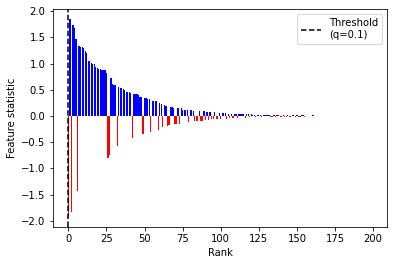

In [8]:
# Create highly correlated design matrix
np.random.seed(123)
n, p = 500, 200
Sigma = knockpy.dgp.AR1(p=p, a=5, b=1)  # AR1 process
X = np.random.randn(n, p) @ np.linalg.cholesky(Sigma).T

# Create random sparse coefficients and sample y | X from a linear model
beta = knockpy.dgp.create_sparse_coefficients(p=p, sparsity=0.3, coeff_size=0.8)
y = np.dot(X, beta) + np.random.randn(n)

# Fit lasso signed maximum stat with fixed-X knockoffs
kf_lasso = KnockoffFilter(fstat="lsm", ksampler="fx")
kf_lasso.forward(X=X, y=y, Sigma=Sigma)
# Plot
kf_lasso.seqstep_plot()

MLR statistics are designed to at least partially avoid this problem, as visualized below. Note that below, the MLR statistics with the highest absolute values are consistently positive, allowing knockoffs to make more discoveries.

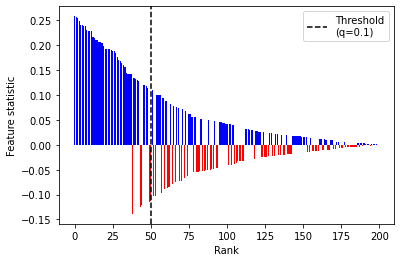

In [9]:
kfilter_mlr = KnockoffFilter(ksampler="fx", fstat="mlr")
kfilter_mlr.forward(X=X, y=y, Sigma=Sigma)
kfilter_mlr.seqstep_plot()

#### Custom feature statistics with ``FeatureStatistic``

The ``knockpy.knockoff_stats.FeatureStatistic`` class also has the ability to turn any model class with a ``fit`` or ``train`` method and a ``predict`` method into a knockoff feature statistic using the swap or swap integral importances introduced in swap and swap integral importances [(Giminez et. al 2018)](https://arxiv.org/abs/1807.06214). This means that after training a predictive model on $[X, \tilde{X}]$ and $y$, to obtain a variable importance for variable $X_j$, the FeatureStatistic class temporarily replaces $X_j$ with $\tilde{X}_j$ and records the decrease in predictive performance of the trained model. After repeating this for all features and knockoffs, this yields knockoff variable importances which can be transformed via an antisymmetric function to create valid feature statistics. 

Using this is easier than it sounds! To do so, begin by initializing any arbitrary model with train/fit and predict methods. Second, wrap it with a FeatureStatistic class. Lastly, pass the FeatureStatistic class to the KnockoffFilter, as shown below:

In [11]:
# Here, we use an arbitrary predictive model
# (in this case, kernel ridge regression)
# to create feature statistics

# Step 1: Initialize the kernel ridge regression object
import sklearn.kernel_ridge

kridge = sklearn.kernel_ridge.KernelRidge(kernel="polynomial")

# Step 2: Wrap it with a feature statistic
kridge_fstat = knockpy.knockoff_stats.FeatureStatistic(model=kridge)

# Step 3: Pass to a knockoff filter
kfilter = KnockoffFilter(ksampler="gaussian", fstat=kridge_fstat)

# Create synthetic dataset with nonlinear response
dgprocess = knockpy.dgp.DGP()
Xnonlin, ynonlin, _, _, _ = dgprocess.sample_data(n=1000, p=200, cond_mean="cubic")

# Run the knockoff filter
rejections = kfilter.forward(X=Xnonlin, y=ynonlin, fdr=0.2)
print(f"Made {rejections.sum()} rejections!")

Made 20.0 rejections!


### Other functionality: group knockoffs and graphical model discovery

#### Group knockoffs

The KnockoffFilter offers some support for sampling group knockoffs for the gaussian and fixed-X knockoff types (see the API reference for more details). New in version 1.1.0, knockpy supports fast computation of group MVR and ME knockoffs, as demonstrated below.

In [12]:
p = X.shape[1]
# Create arbitrary groupings of variables
groups = np.arange(1, p + 1, 1)
groups = np.around(groups / 2 + 0.01).astype("int")
# Initialize the filter as normal
kfilter3 = KnockoffFilter(
    ksampler="gaussian",
    fstat="lasso",
)
# When running the filter, specify the groups
rejections = kfilter3.forward(X, y, groups=groups, fdr=0.2)
print(f"Made {rejections.sum()} rejections!")

Made 60.0 rejections!


#### Gaussian graphical models

New in version 1.2.0, ``knockpy`` includes methods for detecting edges in Gaussian Graphical models, as exemplified below. See [Li and Maathuis (2019)](https://arxiv.org/pdf/1908.11611.pdf) for details.

In [4]:
# Fake data-generating process for Gaussian graphical model
# under global null with no edges
X = np.random.randn(300, 30)

# LCD statistic with FX knockoffs
from knockpy.ggm import KnockoffGGM

gkf = KnockoffGGM(
    fstat="lcd",
    knockoff_kwargs={"method": "mvr"},
)
edges = gkf.forward(X=X, verbose=False)
np.any(edges)

False

### To-dos

We plan to release additional functionality for [conditional knockoffs](https://dmhuang.github.io/tutorials/cknockoff/index.html), more flavors of non-Gaussian knockoff samplers, and more, as well as performance improvements---stay tuned!